# <div align="center" style="color:rgb(51, 238, 255);">Stacked Model - With Pycaret</div>

In [1]:
def set_all_seeds(seed=42):
    """Set all seeds and environment variables for reproducibility"""
    import os
    # Set environment variables before any other imports
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    # Then set other seeds
    import numpy as np
    import random
    np.random.seed(seed)
    random.seed(seed)
    
    # Force single-thread operations
    os.environ['OMP_NUM_THREADS'] = '1'
    os.environ['MKL_NUM_THREADS'] = '1'
    os.environ['OPENBLAS_NUM_THREADS'] = '1'

# First cell of your notebook
set_all_seeds(42) 

# Declare Libraries

In [2]:
# Description: This file contains the data preparation functions for the Beta project.
# Import Libraries
import pycaret
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Union, List
from scipy.stats import mstats
import time
from datetime import datetime
import re
from sklearn.cluster import KMeans
import joblib
from google.cloud import storage
from google.cloud import bigquery
# # Connection to Bigquery
# client = bigquery.Client(project='prj-prod-dataplatform')
import os
path = r'C:\Users\DwaipayanChakroborti\AppData\Roaming\gcloud\legacy_credentials\dchakroborti@tonikbank.com\adc.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path
client = bigquery.Client(project='prj-prod-dataplatform')
os.environ["GOOGLE_CLOUD_PROJECT"] = "prj-prod-dataplatform"

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Settings in this Notebook
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", None)

# Data Preparation

In [18]:
sq = """select * from dap_ds_poweruser_playground.Alpha_18_Feature_Model_All_Applied_SIL_Loans_inference_table where 
digitalLoanAccountId = '6fb1b59d-7880-40c6-a8b9-b97429011dea';

select digitalLoanAccountId,
ln_mature_fspd30_flag,
ln_fspd30_flag,
old_demo_score,
old_cic_score,
credo_old_gen_score,
ts_trusting_social_score,
bu_bureau_score,
credo_cash_score,
credo_sil_score,
credo_flexup_score,
credo_reloan_score,
credo_gen_score,
apps_score,
beta_demo_score,
cic_score,
beta_stack_score,
alpha_stack_score
 	FROM 
    risk_mart.sil_risk_ds_master_20230101_20250309 where ln_mature_fspd30_flag = 1;"""
    
data = client.query(sq).to_dataframe(progress_bar_type='tqdm')

Job ID 563d88bc-1768-4878-9efb-a17ecaa2e81d successfully executed: 100%|██████████|
Downloading: 100%|██████████|


In [19]:
print(f"The shape of the dataframe downloaded - data is:\t{data.shape}")

The shape of the dataframe downloaded - data is:	(151230, 18)


In [20]:
data.groupby(['ln_fspd30_flag'])['digitalLoanAccountId'].nunique()

ln_fspd30_flag
0    133355
1     17710
Name: digitalLoanAccountId, dtype: int64

In [21]:
data['ln_fspd30_flag'].value_counts(dropna=False)

ln_fspd30_flag
0       133489
1        17741
<NA>         0
Name: count, dtype: Int64

In [22]:
data['ln_fspd30_flag'] = data['ln_fspd30_flag'].fillna(2)

In [23]:
data['ln_fspd30_flag'].value_counts(dropna=False)

ln_fspd30_flag
0       133489
1        17741
<NA>         0
Name: count, dtype: Int64

# Model

In [24]:
pycaret.__version__

'3.3.2'

In [27]:
data.columns.values

array(['digitalLoanAccountId', 'ln_mature_fspd30_flag', 'ln_fspd30_flag',
       'old_demo_score', 'old_cic_score', 'credo_old_gen_score',
       'ts_trusting_social_score', 'bu_bureau_score', 'credo_cash_score',
       'credo_sil_score', 'credo_flexup_score', 'credo_reloan_score',
       'credo_gen_score', 'apps_score', 'beta_demo_score', 'cic_score',
       'beta_stack_score', 'alpha_stack_score'], dtype=object)

In [32]:
data[['old_cic_score', 'credo_old_gen_score', 'ts_trusting_social_score']] = data[['old_cic_score', 'credo_old_gen_score', 'ts_trusting_social_score']].astype('float64')
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", categorical_cols)

Categorical columns: ['digitalLoanAccountId']


In [40]:
# import pycaret classification and init setup
from pycaret.classification import *
s = setup(data, target = 'ln_fspd30_flag', session_id = 123, normalize = True, normalize_method = 'minmax', ignore_features='digitalLoanAccountId')

,Description,Value
0,Session id,123
1,Target,ln_fspd30_flag
2,Target type,Binary
3,Original data shape,"(151230, 18)"
4,Transformed data shape,"(151230, 16)"
5,Transformed train set shape,"(105861, 16)"
6,Transformed test set shape,"(45369, 16)"
7,Ignore features,20
8,Numeric features,16
9,Rows with missing values,100.0%


In [41]:
# compare baseline models
best = compare_models(sort = 'F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8827,0.7076,0.0031,0.5098,0.0062,0.0047,0.0314,2.7070
svm,SVM - Linear Kernel,0.8827,0.6888,0.0000,0.0000,0.0000,0.0000,0.0000,0.1990
qda,Quadratic Discriminant Analysis,0.8827,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1530
lightgbm,Light Gradient Boosting Machine,0.8827,0.7103,0.0063,0.5090,0.0124,0.0096,0.0458,0.6090
dummy,Dummy Classifier,0.8827,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1950
ridge,Ridge Classifier,0.8826,0.7067,0.0013,0.4292,0.0026,0.0019,0.0180,0.1950
rf,Random Forest Classifier,0.8826,0.6808,0.0105,0.4775,0.0205,0.0156,0.0568,9.8900
ada,Ada Boost Classifier,0.8826,0.7074,0.0052,0.4445,0.0102,0.0076,0.0370,3.3400
gbc,Gradient Boosting Classifier,0.8825,0.7114,0.0056,0.4397,0.0111,0.0082,0.0385,17.6120
et,Extra Trees Classifier,0.8823,0.6857,0.0087,0.4194,0.0170,0.0124,0.0462,3.3420


# Model Evaluation

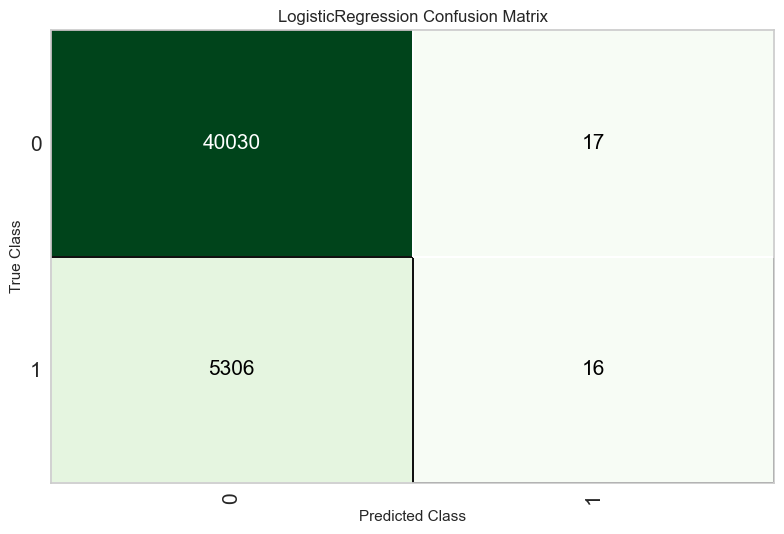

In [42]:
# plot confusion matrix
plot_model(best, plot = 'confusion_matrix')

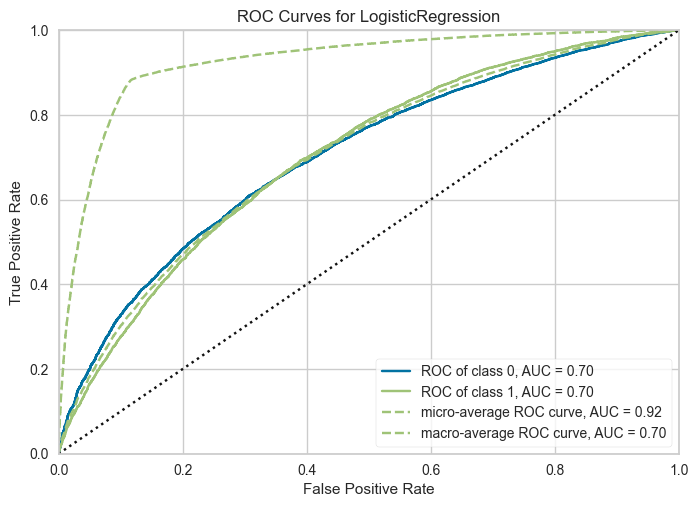

In [44]:
# plot AUC
plot_model(best, plot = 'auc')

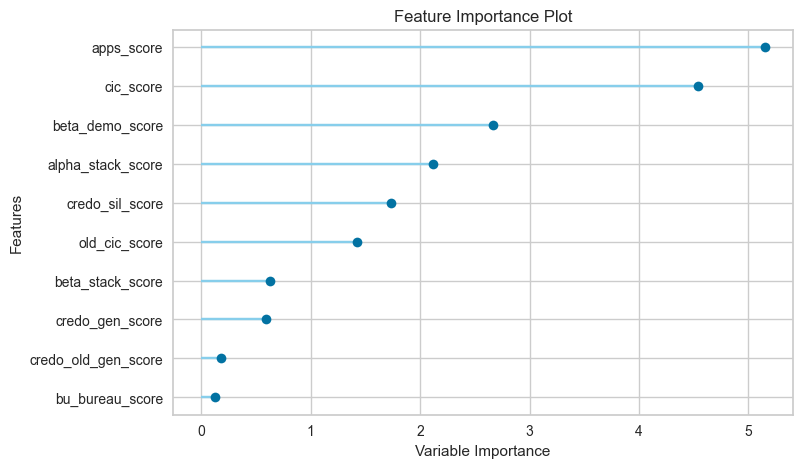

In [45]:
# plot feature importance
plot_model(best, plot = 'feature')

# Prediction

In [47]:
# predict on test set
holdout_pred = predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8827,0.7042,0.0030,0.4848,0.0060,0.0045,0.0308


In [48]:
gini = (2*0.7042)-1

Note: model_output='probability' is currently not supported for linear classifiers models with shap. So defaulting to model_output='logodds' If you really need probability outputs use shap='kernel' instead.
Note: shap values for shap='linear' get calculated against X_background, but paramater X_background=None, so using X instead...
Generating self.shap_explainer = shap.LinearExplainer(model, X)...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Ca

ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=8050): Max retries exceeded with url: /_alive_b97ec766-2867-4cd9-be52-b83c5dd673a1 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000021319CE2E10>: Failed to establish a new connection: [WinError 10049] The requested address is not valid in its context'))